In [1]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-05-15 10:55:27--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: 'airline_passengers.csv'

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-05-15 10:55:27 (6.14 MB/s) - 'airline_passengers.csv' saved [2036/2036]



### Multiplicative Seasonality, Outliers, non-daily data
--------
Using airline passenger data with Prophet library, we will explore a number of features that we could not cover when we applied Prophet to Rossmann data. 

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col=0, parse_dates=True)

df.head() # monthly passenger data 

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
# rename columns, add ds column 

df.columns = ['y']

df['ds'] = df.index

df.head()

,y,ds
Month,,
1949-01-01,112,1949-01-01
1949-02-01,118,1949-02-01
1949-03-01,132,1949-03-01
1949-04-01,129,1949-04-01
1949-05-01,121,1949-05-01


In [5]:
# initialize Prophet and fit 

m = Prophet()

m.fit(df)

11:05:00 - cmdstanpy - INFO - Chain [1] start processing
11:05:00 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
ft_df = m.make_future_dataframe(periods = 12, freq = 'MS')

ft_df.tail(13)

,ds
143,1960-12-01
144,1961-01-01
145,1961-02-01
146,1961-03-01
147,1961-04-01
148,1961-05-01
149,1961-06-01
150,1961-07-01
151,1961-08-01
152,1961-09-01


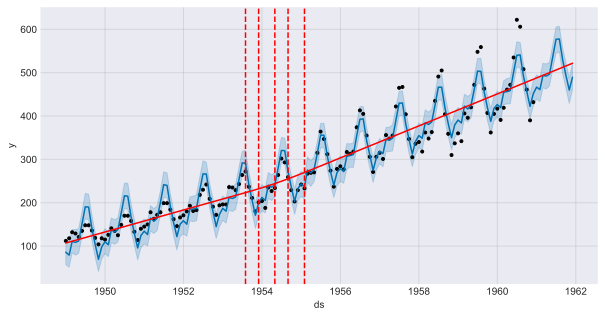

In [7]:
# forecast and plot 

forecast = m.predict(ft_df)

fig, axes = plt.subplots(figsize = (10,5))

m.plot(forecast, ax = axes);
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Model can not capture the increase in the seasonal component. It over-estimates at early times while under-estimates at late times! 

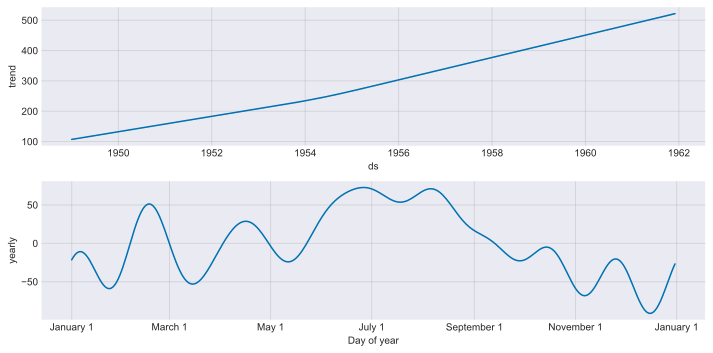

In [10]:
m.plot_components(forecast, figsize = (10,5));

### Another model with multiplicative seasonality
-------
Since the seasonality increase as the trend does, we might expect a model that treats the seasonality component as multiplicative over trend could perform better. Lets have a look. 

In [11]:
m2 = Prophet(seasonality_mode='multiplicative')

m2.fit(df)

11:23:20 - cmdstanpy - INFO - Chain [1] start processing
11:23:20 - cmdstanpy - INFO - Chain [1] done processing


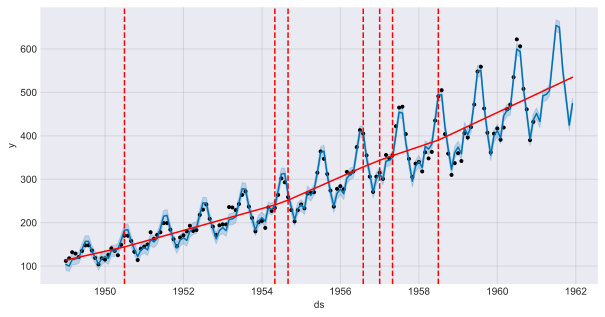

In [12]:
# forecast 

ft_df2 = m2.make_future_dataframe(periods = 12, freq = 'MS')

forecast2 = m2.predict(ft_df2)

fig, axes = plt.subplots(figsize = (10,5))

m2.plot(forecast2, ax = axes);
a = add_changepoints_to_plot(fig.gca(), m2, forecast2)

It looks like this model indeed performs better. We should quantify this later. 

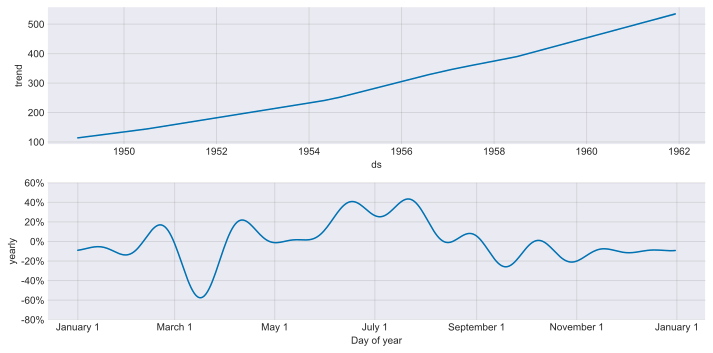

In [14]:
m2.plot_components(forecast2, figsize = (10,5));

In [15]:
# Recall that one way to avoid using multiplicative seasonality is the log transform the passenger data, in order to 'flatten' the accelerated rise in the seasonal peaks 

logdf = df.copy()

logdf['y'] = np.log(logdf['y'])

In [17]:
# initiate and fit 

m3 = Prophet()

m3.fit(logdf)

11:31:18 - cmdstanpy - INFO - Chain [1] start processing
11:31:18 - cmdstanpy - INFO - Chain [1] done processing


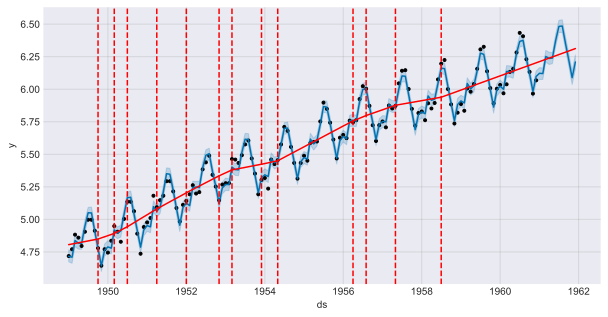

In [19]:
# forecast 

ft_df3 = m3.make_future_dataframe(periods = 12, freq = 'MS')

forecast3 = m3.predict(ft_df3)

fig, axes = plt.subplots(figsize = (10,5))

m3.plot(forecast3, ax = axes);

a = add_changepoints_to_plot(fig.gca(), m3, forecast3)


As compared to the first model (without log transform), this model seems like a bit more sensitive to the change points. However, as compared to the first one it does not have issues capturing the seasonal component thanks to the log transform. 

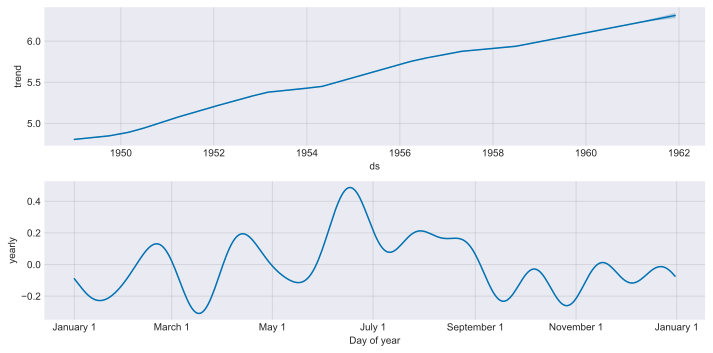

In [20]:
m3.plot_components(forecast3, figsize = (10,5));

### Dealing and understanding of Outliers
-------

In [22]:
# generate fake outliers 

df.loc['1955-01-01', 'y'] = 600
df.loc['1957-06-01', 'y'] = 1



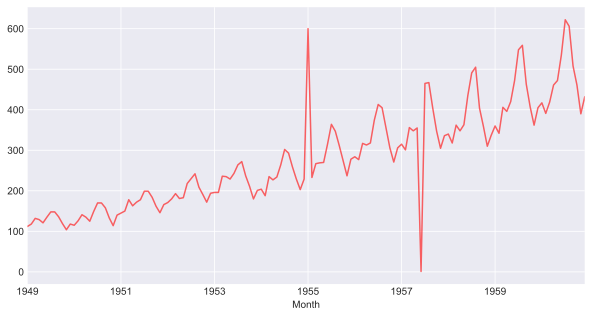

In [23]:
fig, axes = plt.subplots(figsize = (10,5))

df['y'].plot(ax = axes, alpha = 0.6, color = 'red')

axes.grid()

11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing


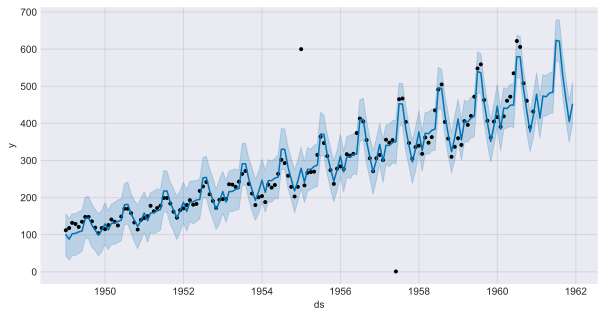

In [24]:
# initiate Prophet, fit and forecast 

mo = Prophet(seasonality_mode='multiplicative')

mo.fit(df)

ft_dfo = mo.make_future_dataframe(periods = 12, freq = 'MS')
forecasto = mo.predict(ft_dfo)

fig, axes = plt.subplots(figsize = (10,5))

mo.plot(forecasto, ax = axes);



The model still does fit fairly well however the prediction intervals are much more wide: i.e the model is not so confident about its predictions due to the presence of outliers!

How do we deal with outliers? Remember that time is the only regressor in Prophet, so missing data is essentially does not lead to any issues. Therefore, the recommended method to deal with outliers is to simply remove them.